# Thyroid Dataset
## Preprocessing

In [2]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.metrics import completeness_score, homogeneity_score, balanced_accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from src.ORCTModel import ORCTModel, predicted_lab, accuracy
from src.cluster import HierarchicalLogisticRegression, best_leaf_assignment

import operator
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [4]:
SEED = 1234
name = "new_thyroid.csv"
DATASET_PATH = os.path.join("datasets", name)
df = pd.read_csv(DATASET_PATH, delimiter=";", header=0)
df = df.drop(columns=["Unnamed: 0"])
columns = list(df.columns)
X = df[columns[:-1]]
y = df[columns[-1]]
feature_names = columns[:-1]

In [5]:
print("Number of rows: {}\nShape: {}".format(len(df), df.shape))
print("The are {} columns".format(len(df.columns)))
print("\nDistinct values for 'Classes' column\n{}\n".format(df["Classes"].value_counts()))

Number of rows: 1594
Shape: (1594, 187)
The are 187 columns

Distinct values for 'Classes' column
2    834
0    384
1    376
Name: Classes, dtype: int64



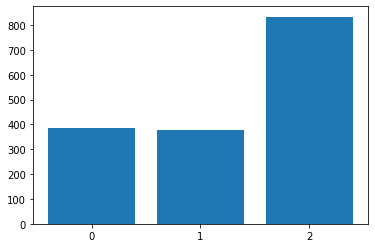

In [6]:
vals = y.unique()
vals.sort()
heights = [len(y[y==x]) for x in vals ]
vals = [str(x) for x in vals]
plt.bar(vals, heights)
plt.show()

In [5]:
X_std = X.copy()
X_std[feature_names] = MinMaxScaler().fit_transform(X[feature_names])
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=SEED)
index_features = list(range(0, len(feature_names) - 1))
index_instances = list(X_train.index)
df_train = pd.concat([X_train, y_train], axis=1)
classes = y.unique().tolist()
classes.sort() # sorted    
classes_en = [i for i in range(len(classes))]



Sample weigthing

In [6]:
occurences = [len(y_train[y_train==x]) for x in classes]
total_samples = sum(occurences)
sample_weight = np.zeros_like(y_train)
for class_index, n_occurr in zip(classes, occurences):
    sample_weight[y_train==class_index]=n_occurr
sample_weight = sample_weight/total_samples

## Clustering

In [7]:
n_leaves = 4
n_clusters = n_leaves
clustering_estimators = []
params = dict(n_clusters=n_clusters, random_state=SEED)
kmeans = KMeans(**params)
clustering_estimators.append(kmeans)

# Spectral clustering not used since it gave looped

params = dict(n_clusters=n_clusters, linkage="single")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="ward")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="complete")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="average")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters)
birch = Birch(**params)
clustering_estimators.append(birch)

In [8]:
from src.cluster import find_best_estimator

for i in range(len(clustering_estimators)):
    try:
        clustering_estimators[i] = clustering_estimators[i].fit(X_train, sample_weight=sample_weight.transpose())
    except:
        clustering_estimators[i] = clustering_estimators[i].fit(X_train)

for estimator in clustering_estimators:
    print(estimator.__class__.__name__, homogeneity_score(y_train, estimator.labels_))
    
best_estimator = find_best_estimator(clustering_estimators, homogeneity_score, y_train)
print("The best estimator is {}".format(best_estimator))

KMeans 0.03071630923835349
AgglomerativeClustering 0.0002648202557415631
AgglomerativeClustering 0.027214759684686778
AgglomerativeClustering 0.005515461053430391
AgglomerativeClustering 0.007174716837755318
Birch 0.01720381013165665
The best estimator is KMeans(n_clusters=4, random_state=1234)


/home/oscarpindaro/miniconda3/envs/decision_trees/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(


## Leaves assignment

In [9]:
from src.cluster import best_leaf_assignment
for estimator in clustering_estimators:
    assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=estimator.labels_, 
                                      true_labels=y_train, metric=completeness_score)
    print("For the estimator {}, the assignment {} has a score of {}".format(estimator.__class__.__name__,
                                                                             assignment, score))

For the estimator KMeans, the assignment [0, 3, 1, 2] has a score of 0.008101878533974389
For the estimator AgglomerativeClustering, the assignment [0, 3, 1, 2] has a score of 0.009629814142041693
For the estimator AgglomerativeClustering, the assignment [0, 2, 1, 3] has a score of 0.007623468537665565
For the estimator AgglomerativeClustering, the assignment [0, 3, 1, 2] has a score of 0.004451263856176911
For the estimator AgglomerativeClustering, the assignment [0, 1, 2, 3] has a score of 0.07395048274034136
For the estimator Birch, the assignment [0, 2, 1, 3] has a score of 0.009227622508936797


## Parameters Initialization

In [10]:
from src.cluster import HierarchicalLogisticRegression
HLR = HierarchicalLogisticRegression(n_classes=len(np.unique(y_train)), n_leaves=n_leaves, prediction_type="deterministic", random_state=0,
                                     logistic_params={"class_weight": "balanced"})

The clustering algorithm behave like random classifiers. In this case, since there is a strong imbalance, *balanced_accuracy_score* is used to computed the real accuracy.

In [11]:
best = clustering_estimators[0]
best_accuracy = 0
i = 0
for estimator in clustering_estimators:
    """
    print(estimator)
    print(np.unique(estimator.labels_))
    for un in np.unique(estimator.labels_):
        print(len(estimator.labels_[estimator.labels_==un]))
    """
    assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=estimator.labels_, 
                                  true_labels=y_train, metric=completeness_score)
    HLR = HLR.fit(X_train.to_numpy(), y_train, cluster_labels=estimator.labels_, leaves_assignment=assignment )
    accuracy = balanced_accuracy_score( y_test, HLR.predict(X_test.to_numpy()))
    print("{} accuracy:{}".format(estimator, accuracy))
    if accuracy > best_accuracy:
        best = clustering_estimators[i]
        best_accuracy = accuracy
    i +=1
print("The best was {} with score {}".format(best, best_accuracy))

KMeans(n_clusters=4, random_state=1234) accuracy:0.3333333333333333
AgglomerativeClustering(linkage='single', n_clusters=4) accuracy:0.3333333333333333
AgglomerativeClustering(n_clusters=4) accuracy:0.3333333333333333
AgglomerativeClustering(linkage='complete', n_clusters=4) accuracy:0.3333333333333333
AgglomerativeClustering(linkage='average', n_clusters=4) accuracy:0.1693292806484296
Birch(n_clusters=4) accuracy:0.3333333333333333
The best was KMeans(n_clusters=4, random_state=1234) with score 0.3333333333333333


In [12]:
assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=y_train, 
                                      true_labels=y_train, metric=completeness_score)
print("The true labelling has assignment {} with score {}".format(assignment, score))
HLR = HierarchicalLogisticRegression(n_classes=len(np.unique(y_train)),
                                     n_leaves=n_leaves, prediction_type="deterministic",
                                     random_state=0)
HLR = HLR.fit(X_train.to_numpy(), y_train, cluster_labels=y_train, leaves_assignment=assignment)
accuracy = balanced_accuracy_score( y_test, HLR.predict(X_test.to_numpy()))
print("Accuracy using true labellling: {}".format(accuracy))

The true labelling has assignment [0, 2, 1, 3] with score 1.0000000000000042
Accuracy using true labellling: 0.3650793650793651


## ORCT model

In [13]:
def B_in_NR(model, i):
    if i == 4:
        return []
    elif i == 5:
        return [2]
    elif i == 6:
        return [1]
    elif i == 7:
        return [1, 3]


def B_in_NL(model, i):
    if i == 4:
        return [1, 2]
    elif i == 5:
        return [1]
    elif i == 6:
        return [3]
    elif i == 7:
        return []


def I_k(model, i):
    if i == 0:
        return I_in_k[0]
    elif i == 1:
        return I_in_k[1]
    elif i == 2:
        return I_in_k[2]

In [14]:
BF_in_NL_R = {4: [], 5: [2], 6: [1], 7: [1, 3]}
BF_in_NL_L = {4: [1, 2], 5: [1], 6: [3], 7: []}
I_in_k = {i: list(df_train[df_train['Classes'] == i].index) for i in range(len(classes))}
my_W = {(i, j): 0.5 if i != j else 0 for i in classes_en for j in classes_en}
index_instances = list(X_train.index)
my_x = {(i, j): df_train.loc[i][j] for i in index_instances for j in index_features}

In [15]:
a = np.stack(HLR.coef_).transpose()
mu = np.stack(HLR.intercept_)
C = HLR.leaf_class_probs_.transpose()
# j+1 due to the convention for the branch nodes (numbered from 1)
# it's in the form
# (0,1) (0,2) (0,3)
# (1,1) (1,2) (1,3) and so one
init_a = {(i, j + 1): a[i, j] for i in range(len(index_features)) for j in range(3)}
# in the form (1) (2) (3)
init_mu = {(i + 1): mu[i] for i in range(3)}
# shape (n_classes, n_leaves), and leaves are the last 4 numbers of 2^h -1
# (0,4) (0,5) (0,6) (0,7)
# (1,4) ---
init_c = {(i, j + 4): C[i, j] for i in classes_en for j in range(4)}

In [16]:
model = ORCTModel(I_in_k=I_in_k, I_k_fun=I_k, index_features=index_features, BF_in_NL_R=BF_in_NL_R,
                      B_in_NR=B_in_NR, B_in_NL=B_in_NL, error_weights=my_W, x_train=my_x, init_a=init_a,
                      init_mu=init_mu, init_C=init_c)


    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


In [17]:
ipopt_path = "~/miniconda3/envs/decision_trees/bin/ipopt"
model.solve(ipopt_path)

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    99390
Number of nonzeros in inequality constraint Jacobian.:      252
Number of nonzeros in Lagrangian Hessian.............:    28829

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error in an AMPL evaluation. Run with "ha

ValueError: Cannot load a SolverResults object with bad status: error

In [ ]:
val = model.extraction_va()


labels = predicted_lab(model.model, X_test, val, index_features)
a = accuracy(y_test.to_numpy(), labels)